## Library Prerequisites

In [1]:
import random
import numpy as np
np.random.seed(42)
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## One-hot Encoding

In [2]:
def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

## Preprocessing

In [3]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
x = (x/255.).astype(np.float32)
y = to_categorical(y)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

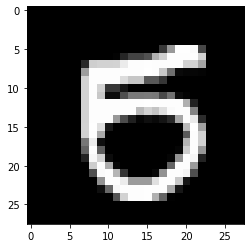

In [6]:
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

## Network Implementation

![alt text](network.jpeg "2 hidden-layers Neural Network")

In [9]:
class NumpyNet():
    def __init__(self, nodes, epochs=20, lr=0.5):
        self.nodes = nodes # neurons in each layer
        self.epochs = epochs
        self.lr = lr # learning rate
        self.params = {}
        self.n_weights = len(nodes) - 1       
        self.create()
        
    def create(self): # init network weights
        # three network weights
        for i in range(self.n_weights):
            self.params['W'+str(i+1)] = np.random.randn(self.nodes[i+1], self.nodes[i]) * np.sqrt(1. / self.nodes[i+1]) #multiply with small values
    
    def relu(self, x, deriv = False):
        if deriv:
            return x > 0 #derivative of relu
        return np.maximum(0, x)
    
    def softmax(self, x, deriv = False):
        exps = np.exp(x - x.max())
        if deriv:
            return exps/np.sum(exps, axis=0) * (1- exps/np.sum(exps, axis=0)) #derivative of softmax
        return exps / np.sum(exps, axis=0)
    
    def forward(self, x):
        out = x
        self.params['O0'] = out
        for i in range(self.n_weights):
            order = i + 1
            self.params['Z'+str(order)] = np.dot(self.params['W'+str(order)], out)
             
            if order==self.n_weights: 
                out = self.softmax(self.params['Z'+str(order)])
            else:
                out = self.relu(self.params['Z'+str(order)])
            self.params['O'+str(order)] = out
        return out
    
    def backward(self, y, output):
        wparams = {}
        #the last layer
        error = 2 * (output - y)/output.shape[0] * self.softmax(self.params['Z'+str(self.n_weights)], deriv=True)
        wparams['W'+str(self.n_weights)] = np.outer(error, self.params['O'+str(self.n_weights-1)])

        #the former layers
        for i in range(1, self.n_weights):
            error = np.dot(self.params['W'+str(self.n_weights-i+1)].T, error) * self.relu(self.params['Z'+str(self.n_weights-i)], deriv=True)
            wparams['W'+str(self.n_weights-i)] = np.outer(error, self.params['O'+str(self.n_weights-i-1)])
            
        return wparams
    
    def update(self, wparams, lr):
        for key, v in wparams.items():
            self.params[key] -= lr * v #update network weight with changes calculated before
            
    def accuracy(self, x_test, y_test):
        predictions = []
        for x, y in zip(x_test, y_test):
            output = self.forward(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        return np.mean(predictions)
    
    def train_(self, x_train, y_train, x_test, y_test):#train with SGD
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward(x)
                wparams = self.backward(y, output)
                self.update(wparams)
                
            acc = self.accuracy(x_test, y_test)
            print("Epoch {0} -- Accuracy {1:.05f}%".format(iteration, acc))
            
    def train(self, x_train, y_train, x_test, y_test, batch_size=1, lr_decay = False):#train with mini-batch SGD
        if batch_size < 2:
            return self.train_(x_train, y_train, x_test, y_test)
        
        for iteration in range(self.epochs):
            traindata = np.concatenate((x_train, y_train), axis=1)
            random.shuffle(traindata)
            batches = [traindata[k:k+batch_size] for k in range(0, len(traindata), batch_size)] # mini batch
            
            lr = self.lr* (self.epochs-iteration)/self.epochs if lr_decay else self.lr # learning rate decay
            for batch in batches:
                wparams_ = defaultdict(list)
                wparams = {}
                for data in batch:
                    x, y = data[:784], data[784:]
                    output = self.forward(x)
                    wps = self.backward(y, output)
                    for key, v in wps.items():
                        wparams_[key].append(v)
                        
                for key, v in wparams_.items():        
                    wparams[key] = np.mean(wparams_[key],axis=0)#mean of mini batch weight changes
                self.update(wparams, lr)  # update weights in each mini batch
                
            acc = self.accuracy(x_test, y_test)
            print("Epoch {0} -- LR {1:.05f} -- Accuracy {2:.03f}%".format(iteration,lr, acc*100))          
    

In [115]:
model = NumpyNet(nodes = [784, 128, 64, 10], epochs = 20, lr = 0.5)
model.train(x_train,y_train,x_test,y_test, batch_size = 4, lr_decay = True)

Epoch 0 -- LR 0.50000 -- Accuracy 0.94943%
Epoch 1 -- LR 0.47500 -- Accuracy 0.95886%
Epoch 2 -- LR 0.45000 -- Accuracy 0.95657%
Epoch 3 -- LR 0.42500 -- Accuracy 0.96686%
Epoch 4 -- LR 0.40000 -- Accuracy 0.96924%
Epoch 5 -- LR 0.37500 -- Accuracy 0.96876%
Epoch 6 -- LR 0.35000 -- Accuracy 0.97010%
Epoch 7 -- LR 0.32500 -- Accuracy 0.96971%
Epoch 8 -- LR 0.30000 -- Accuracy 0.96971%
Epoch 9 -- LR 0.27500 -- Accuracy 0.96924%
Epoch 10 -- LR 0.25000 -- Accuracy 0.97229%
Epoch 11 -- LR 0.22500 -- Accuracy 0.97095%
Epoch 12 -- LR 0.20000 -- Accuracy 0.97238%
Epoch 13 -- LR 0.17500 -- Accuracy 0.97324%
Epoch 14 -- LR 0.15000 -- Accuracy 0.97352%
Epoch 15 -- LR 0.12500 -- Accuracy 0.97419%
Epoch 16 -- LR 0.10000 -- Accuracy 0.97390%
Epoch 17 -- LR 0.07500 -- Accuracy 0.97410%
Epoch 18 -- LR 0.05000 -- Accuracy 0.97343%
Epoch 19 -- LR 0.02500 -- Accuracy 0.97381%


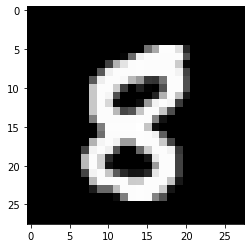

In [317]:
plt.imshow(x_test[110].reshape(28, 28), cmap='gray') #test a image

In [320]:
np.argmax(model.forward(x_test[110])) #predict the class of that image

8